<a href="https://colab.research.google.com/github/jufabeck2202/KI-Lab/blob/main/%5BKI_Lab2021%5D_Assignment_4_OWCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Overview:

• In this assignment we want to build a model that can generate German nouns
given a prefix as input.
Example: Input „Jahr" → Output: „Jahrmarkt“ .

• For this purpose, we load German language data and filter it for nouns with spaCy.

• We then use a simple RNN to learn to generated names.

• In a second step, we switch to a more sophisticated LSTM model and compare the
results.


1. Go to the following Git repo which contains a dataset of German articles:
https://github.com/tblock/10kGNAD
2. Download the file train.csv	from there and import it into a notebook.
3. Drop the label and only use the sentence in each line (the part after the first ; ).
4. Use spaCy to get all nouns in the whole file.
5. Filter out the nouns that have characters wich are not in all_letters (see
code snippet below). The remaining set of nouns constitute our training data.
6. Go through the PyTorch tutorial on name generation. Clone the notebook, execute it
and understand what is going on.
7. Use the same architecture to train a language model on the nouns that were extracted
from the German dataset in step 1 to 5. (Note: We do not need a „category“, you have
to remove everything that belongs to „category“ from the code).
8. Extend the sampling logic in the sample function sucht that:
  
  i. The model extends any given prefix string by first feeding the prefix into the RNN
and then start generating new characters. (Currently the model only samples based
on a given starting letter).
  
  ii. Currently the model uses the highest score during sampling. Change that into
drawing a real sample from the softmax distribution.
9. Choose 10 random words from the training data and randomly cut-off a prefix. For
every of those prefixes give an output for:
  1. The model extending the prefix with the max score approach.
  2. The mode extending the prefix with a real sampling approach.
  3. Randomly pick characters from all_letters to extend the prefix (this is just for
comparison reasons, i.e. how would a complete random generation look like).
Bonus task (which will be very helpful for the next assignment):
• Use an LSTM as described here (but without the embeddings) to train the model.
• Feed the whole word at once to the LSTM (i.e. not a single characters at a time).
• Generate some words to see the results

Do not expect the models to generate always meaningful words. The model should
output words that are in some sense similar to valid words and which look much closer
to real words than randomly generated output


In [1]:
!pip install -U spacy[cuda100] de &> /dev/null
!python -m spacy download de &> /dev/null
!pip install -q "tqdm>=4.36.1" &> /dev/null

In [2]:
import pandas as pd
import torch
import spacy
spacy.prefer_gpu()
nlp_ger = spacy.load("de")
from tqdm import tqdm
import string
import torch
import torch.nn as nn
import random
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/tblock/10kGNAD/master/articles.csv', names=['temp','Data'], error_bad_lines=False, sep=';')
df = df.drop(columns=['temp'])
df

,Data
0,"Die ARD-Tochter Degeto hat sich verpflichtet, ..."
1,App sei nicht so angenommen worden wie geplant...
2,"'Zum Welttag der Suizidprävention ist es Zeit,..."
3,Mitarbeiter überreichten Eigentümervertretern ...
4,Service: Jobwechsel in der Kommunikationsbranc...
...,...
10268,Die Fundstelle in Südengland ist Unesco-Weltku...
10269,Im Team arbeitet auch ein Inspektor der sudane...
10270,Die zentrale Frage des Projekts: Siedelten Ägy...
10271,Klimatische Verschlechterungen dürften zur Auf...


In [4]:
nouns = []
for index, row in tqdm(df.iterrows(), total=df.shape[0], position=0, leave=True):
    text = nlp_ger(row.Data)
    for word in text:
      if word.pos_ == 'NOUN':
        nouns.append(word.text)

100%|██████████| 10273/10273 [10:48<00:00, 15.84it/s]


In [5]:
print(len(nouns))
nouns = list(dict.fromkeys(nouns))
print(f"Number of German Nouns {len(nouns)}")
all_letters = string.ascii_letters + 'ÄÖÜäöüß'
nouns = [word for word in nouns if all(ch in list(all_letters) for ch in word)] 
print(f"Number of German sanitized Nouns {len(nouns)}")
n_letters = len(all_letters) + 1

809777
Number of German Nouns 131574
Number of German sanitized Nouns 102361


In [6]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        input_combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [7]:
# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

def randomTrainingPair():
    line = randomChoice(nouns)
    return line
    
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

In [8]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    line = randomTrainingPair()
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    
    input_line_tensor = input_line_tensor.cuda()
    target_line_tensor = target_line_tensor.cuda()
    return input_line_tensor, target_line_tensor

In [9]:
input, output = randomTrainingExample()
print(input.shape)

torch.Size([15, 1, 60])


In [10]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

In [11]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [12]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 10000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()
for iter in tqdm(range(1, n_iters + 1),position=0, leave=True):
    output, loss = train(*randomTrainingExample()) 
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

 10%|█         | 10007/100000 [02:39<23:13, 64.60it/s]

2m 39s (10000 10%) 2.6460


 20%|██        | 20009/100000 [05:20<21:16, 62.66it/s]

5m 20s (20000 20%) 2.7869


 30%|███       | 30007/100000 [08:00<20:32, 56.80it/s]

7m 59s (30000 30%) 2.1014


 40%|████      | 40011/100000 [10:39<15:23, 64.97it/s]

10m 39s (40000 40%) 2.2101


 50%|█████     | 50008/100000 [13:18<12:22, 67.30it/s]

13m 18s (50000 50%) 2.5336


 60%|██████    | 60010/100000 [15:58<11:11, 59.51it/s]

15m 58s (60000 60%) 4.4099


 70%|███████   | 70009/100000 [18:38<08:20, 59.98it/s]

18m 38s (70000 70%) 2.2410


 80%|████████  | 80008/100000 [21:19<05:15, 63.29it/s]

21m 19s (80000 80%) 2.9489


 90%|█████████ | 90008/100000 [23:59<02:44, 60.58it/s]

23m 59s (90000 90%) 2.2628


100%|██████████| 100000/100000 [26:38<00:00, 62.55it/s]

26m 38s (100000 100%) 2.2621


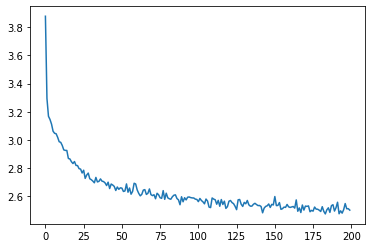

In [13]:
plt.figure()
plt.plot(all_losses)

In [40]:
max_length = 20

# Sample from a category and starting letter
def sample(start_letters='A'):
    with torch.no_grad():  # no need to track history in sampling
        hidden = rnn.initHidden()
        
        # set output to current prefix
        generated_word = start_letters

        for letter in start_letters[:-1]:
          input_single_letter = inputTensor(letter)
          _ , hidden = rnn(input_single_letter[0], hidden)

        input = inputTensor(start_letters[0])
        for i in range(max_length):
            output, hidden = rnn(input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
              #reached end of line
                break
            else:
                letter = all_letters[topi]
                generated_word += letter
            #next input
            input = inputTensor(letter)

        return generated_word


In [58]:
sample(start_letters="Tobi")

'Tobieren'

In [107]:
def evaluate_model(wordcount = 10, min_prefix =3):
  for i in range(wordcount):
    test_word = randomChoice(nouns)
    if len(test_word)>=3:
      print(f"{test_word}:")
      prefix_len = random.randint(1, len(test_word) - 2)
      test_prefix = test_word[: ]
      print(f"Prefix: {test_prefix} Top: {sample(test_prefix)}")
    else:
      i -=1

evaluate_model(1000)

Zivilengagement:
Ziv:
Wasserstoffatome:
Wasserstoffat:
Intensitäten:
In:
Kongregation:
Kong:
Gelenk:
Gel:
Biobranche:
B:
Walfangkommission:
Wal:
Schulabteilung:
Schula:
Stinkefinger:
Stin:
Klausurheft:
Klausurh:
South:
Sou:
Taxlern:
T:
Falkner:
Falk:
Linksaußen:
Linksa:
Prüfberichts:
P:
Subversionsschlager:
Subversionsschlag:
Konstruktionsdetails:
Konstruktionsdeta:
Hasskommentare:
Hasskomm:
Wirtschaftsstaatssekretär:
Wirtschaftsstaatssek:
Transportmanagements:
Tran:
Vorwahlmarathon:
Vorwahlmarath:
Umrüstung:
Umrüstu:
Talk:
T:
Wüstensand:
Wüste:
Quotenkurs:
Quote:
Landungsschiff:
Landung:
Verlust:
Ve:
Wider:
W:
Kinnbart:
Kinn:
Siegestrophäe:
Siegestro:
Regierungskollege:
Regier:
Speerspitze:
Speersp:
Geisterstadt:
Gei:
Wehrhaft:
We:
Meniskuseinriss:
Meniskus:
Lizenzierungsverfahrens:
Lizen:
Entspanntheit:
Entspannthe:
Rechtskomitee:
Rechts:
Rosenmontag:
Rosenm:
Communities:
Co:
Mujaheddin:
Muj:
Fünfzigerjahre:
Fünfzig:
Feiertagen:
Feierta:
Neuling:
Ne:
Scheidungsrichter:
Scheidungsrich